In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import warnings
import gc

In [6]:
AS_UPDATES_ROOT_DIR = './data/asn_updates'

as_updates = {}
as_updates_dirs = sorted(glob(AS_UPDATES_ROOT_DIR+'/*'))
for dir_path in tqdm(as_updates_dirs):
    asn = dir_path.split('/')[-1]

    if asn not in ['138146', '25139']:
        continue
    
    as_updates_files = sorted(glob(dir_path+'/*'))
    as_df_list = [pd.read_csv(file_path) for file_path in as_updates_files]
    as_df =  pd.concat(as_df_list).reset_index(drop=True)
    del as_df_list
    gc.collect()
    as_df = as_df.sort_values('time')
    as_df['period_before_update'] = as_df.time - as_df.time.shift(1)
    as_updates[asn] = as_df    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 66.73it/s]


In [7]:
df_25139 = as_updates['25139']
df_25139['minute'] = df_25139.time // 60
timestamps_extended = np.arange(int(df_25139.minute.min()), int(df_25139.minute.max()))
df_25139 = df_25139.groupby('minute')[['prefix']]\
                   .count()\
                   .rename(columns={'prefix': 'updates'})\
                   .reindex(timestamps_extended)\
                   .fillna(0)

In [10]:
df_25139.shape

(20079, 1)

In [30]:
def simulate_arima(time_series, order, trend='c', pred_steps=10, test_size=0.2):
    n_samples = len(time_series)
    if type(test_size)==float:
        pred_start_idx = round(n_samples * (1-test_size))
    elif type(test_size)==int:
        pred_start_idx = n_samples - test_size
    else:
        raise TypeError('test_size should be an integer or a float.')

    print('#Samples:', n_samples, '| Start Training Size:', pred_start_idx, '| Test Size:', n_samples - pred_start_idx)
        
    all_preds = []
    for i in tqdm(range(pred_start_idx, len(time_series), pred_steps)):
        curr_data = time_series.iloc[:i].reset_index(drop=True)
        model = ARIMA(curr_data, order=order, trend=trend).fit()    
        y_pred = model.forecast(steps=pred_steps)
        all_preds.append(y_pred)
    
    return all_preds, model

In [24]:
df_25139.shape[0]

20079

In [59]:
pred_steps = 15
test_size = 300
all_preds, model = simulate_arima(df_25139.updates, (25, 0, 0), pred_steps=pred_steps, test_size=test_size)

#Samples: 20079 | Start Training Size: 19779 | Test Size: 300


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [25:28<00:00, 76.43s/it]


In [63]:
y_pred = np.array(all_preds).reshape(-1)
y_true = df_25139.updates.iloc[-test_size:]

In [64]:
print('RMSE:', np.sqrt(mean_squared_error(y_true, y_pred)))
print('R2:', r2_score(y_true, y_pred))

RMSE: 7.415322581799445
R2: 0.6541361834986616


In [65]:
sns.set_theme(rc={'figure.figsize':(12,6)})

<Axes: ylabel='updates'>

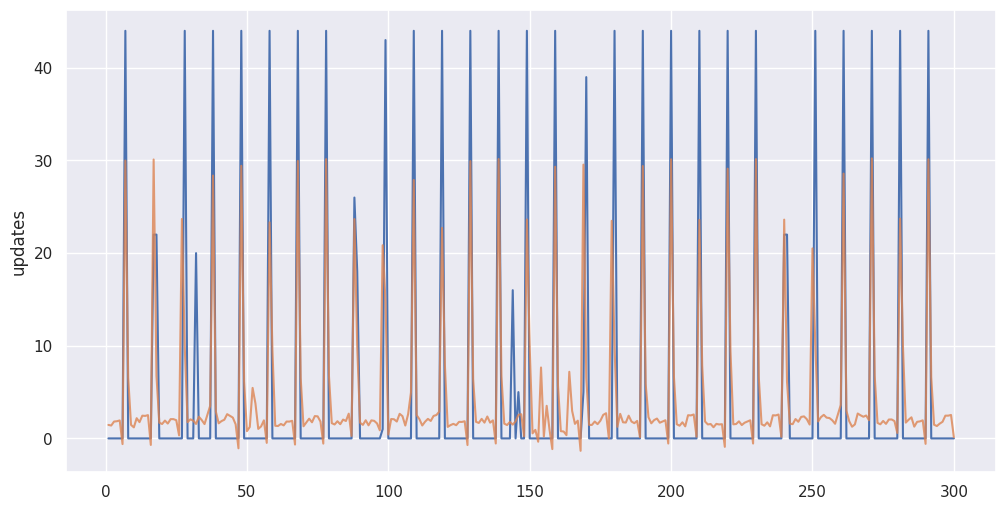

In [68]:
sns.lineplot(x=range(1, test_size+1), y=y_true)
sns.lineplot(x=range(1, test_size+1), y=y_pred, alpha=0.8)

In [69]:
y_preds = np.array(all_preds)
y_true_reshaped = y_true.to_numpy().reshape(-1, pred_steps)

for i in range(pred_steps):
    y_pred_step = y_preds[:,i]
    y_true_step = y_true_reshaped[:, i]
    # y_pred[y_pred<0] = 0
    print('Predicted Step:', i+1, '| RMSE:', np.sqrt(mean_squared_error(y_true_step, y_pred_step)), '| R2:', r2_score(y_true_step, y_pred_step))

Predicted Step: 1 | RMSE: 5.207519592258262 | R2: 0.753716644230736
Predicted Step: 2 | RMSE: 5.025302862560934 | R2: 0.3653262412550107
Predicted Step: 3 | RMSE: 5.928795560444994 | R2: 0.8125800224070794
Predicted Step: 4 | RMSE: 7.869234996215642 | R2: 0.6425229283706975
Predicted Step: 5 | RMSE: 8.777910580168692 | R2: 0.6640101420307749
Predicted Step: 6 | RMSE: 5.3743046548847975 | R2: 0.8342335254619123
Predicted Step: 7 | RMSE: 4.0521608671525 | R2: 0.8214440224740963
Predicted Step: 8 | RMSE: 6.837146383482926 | R2: 0.7311058791804675
Predicted Step: 9 | RMSE: 8.667351628557052 | R2: 0.6931595337408969
Predicted Step: 10 | RMSE: 6.939233083425475 | R2: 0.723640060915366
Predicted Step: 11 | RMSE: 9.357646378019284 | R2: 0.4945055159483488
Predicted Step: 12 | RMSE: 6.064489959558033 | R2: 0.0
Predicted Step: 13 | RMSE: 9.127022454624052 | R2: 0.5726102360719734
Predicted Step: 14 | RMSE: 9.19469704317373 | R2: 0.5347396746698162
Predicted Step: 15 | RMSE: 9.528471525253872 | R

In [70]:
pred_steps = 5
test_size = 60
all_preds, model = simulate_arima(df_25139.updates, (25, 0, 0), pred_steps=pred_steps, test_size=test_size)

#Samples: 20079 | Start Training Size: 20019 | Test Size: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [15:17<00:00, 76.49s/it]


In [71]:
y_pred = np.array(all_preds).reshape(-1)
y_true = df_25139.updates.iloc[-test_size:]

In [72]:
print('RMSE:', np.sqrt(mean_squared_error(y_true, y_pred)))
print('R2:', r2_score(y_true, y_pred))

RMSE: 6.511838587933298
R2: 0.7230887060872055


<Axes: ylabel='updates'>

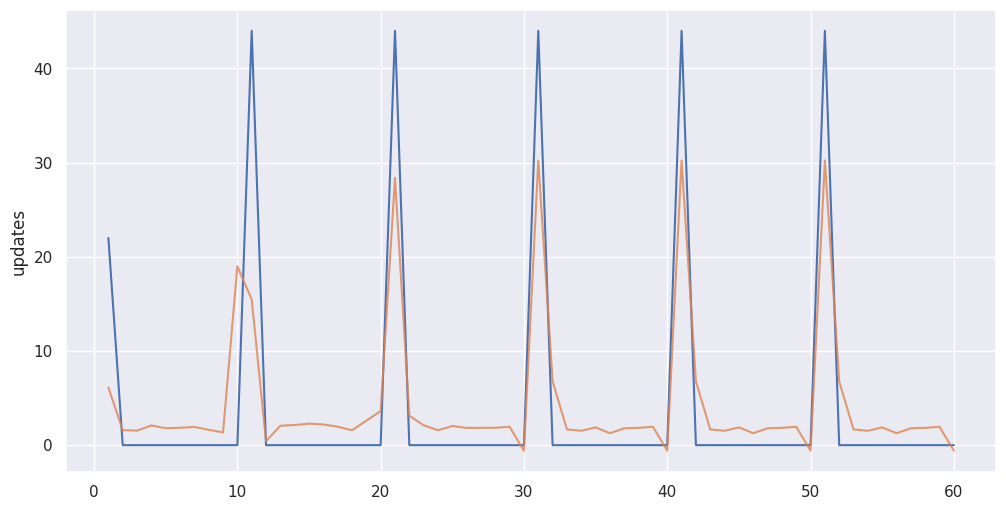

In [73]:
sns.lineplot(x=range(1, test_size+1), y=y_true)
sns.lineplot(x=range(1, test_size+1), y=y_pred, alpha=0.8)